In [0]:
%tensorflow_version  2.x
! pip install -q keras==2.3.0

     |████████████████████████████████| 378kB 6.6MB/s 


In [0]:
# Per sapere che GPU è assegnata 

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer, classification_report
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier


from xgboost.sklearn import XGBClassifier
import xgboost

from keras import models, layers, optimizers, metrics, callbacks


from keras.wrappers.scikit_learn import KerasClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Funzione per standardizzare
def standardize(data, columns):
    for i in columns:
        data[i] = (data[i] - data[i].mean()) / data[i].std()
    return data

In [0]:
def remove_rare_values_inplace(df_frame, column_list, threshold):

    insignificant_population = int(np.floor(threshold * len(df_frame)))
    for cat in column_list:
        freqs = collections.Counter(df_frame[cat])
        other = [i for i in freqs if freqs[i] < insignificant_population]
        for i in other:
            df_frame[cat].replace(i, 'other', inplace=True)

# Load Data

In [0]:
data = pd.read_csv('/content/drive/My Drive/progetto_aml/dataset/train_users_2.csv')
#test = pd.read_csv("/content/drive/My Drive/progetto_aml/dataset/test_users.csv")
sessions = pd.read_csv("/content/drive/My Drive/progetto_aml/dataset/sessions.csv")
#age_gender = pd.read_csv("/content/drive/My Drive/progetto_aml/dataset/age_gender_bkts.csv")

In [0]:
data.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [0]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


# Preprocess

In [0]:
# Scartiamo la feature "date_first_booking" inutile

data.drop("date_first_booking", axis = 1, inplace = True)

## Classe obiettivo

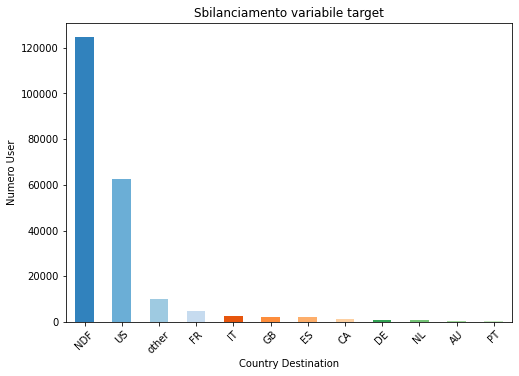

In [0]:
data.country_destination.value_counts().plot(kind='bar', rot = 45,color=plt.cm.tab20c(np.arange(len(data.country_destination.unique()))))
plt.xlabel("Country Destination")
plt.ylabel("Numero User")
plt.title("Sbilanciamento variabile target")
plt.savefig("prova.svg", format="svg")

# Classe obietivo è sbilanciata, la maggior parte degli utenti non prenotatimestamp_first_active

## Age

In [0]:
data["age"].describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [0]:
data["age"].value_counts(ascending=False, dropna=False)

NaN       87990
30.0       6124
31.0       6016
29.0       5963
28.0       5939
          ...  
1927.0        1
2008.0        1
1926.0        1
1938.0        1
1925.0        1
Name: age, Length: 128, dtype: int64

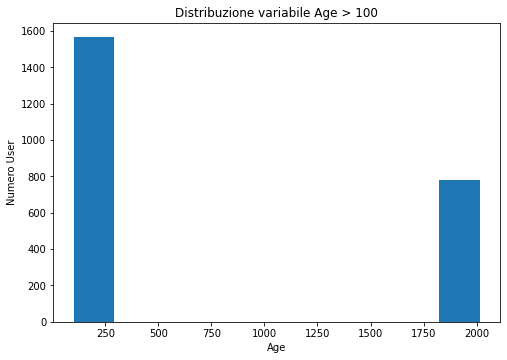

In [0]:
data[data["age"] > 100].age.hist(grid = 0)
plt.xlabel("Age")
plt.ylabel("Numero User")
plt.title("Distribuzione variabile Age > 100")
plt.savefig("prova_age.svg", format = "svg")

Ci sono persone iscritte con meno di 18 anni, il cui va contre le regole di Airbnb, e persone che superano di granlunga i 100 anni.

Alcuni user probabilmente hanno inserito l'anno di nascita (es. 1990) altri potrebbero essere errori o non volontà di comunicare la vera età (es. 230).

In [0]:
# Si prova a sistemare gli user che hanno inserito l'anno di nascita (il dataset risale al 2015)

user_with_year_age_mask = data['age'] > 1000
data.loc[user_with_year_age_mask, 'age'] = 2015 - data.loc[user_with_year_age_mask, 'age']

In [0]:
# Si pongono dei limiti all'età: sia assume che sotto i 18 anni e sopra i 100 siano errori


data.loc[(data['age'] > 100) | (data['age'] < 18), 'age'] = np.nan
data["age"] = (data["age"] - data["age"].mean()) / data["age"].std()

## Sistemazione date

In [0]:
data["date_account_created"] = pd.to_datetime(data["date_account_created"])
data["timestamp_first_active"] = pd.to_datetime(data["timestamp_first_active"], format='%Y%m%d%H%M%S')

In [0]:
date_account_created = pd.DatetimeIndex(data['date_account_created'])
date_first_active = pd.DatetimeIndex(data['timestamp_first_active'])

In [0]:
# Split date in giorno, settimana, mese, anno

# data['day_account_created'] = date_account_created.day # correlata con "day_first_active"
# data['weekday_account_created'] = date_account_created.weekday # correlata con "weekday_first_active"
# data['week_account_created'] = date_account_created.week # altamente correlata al "month_account_created"
# data['month_account_created'] = date_account_created.month # correlata con "month_first_active"
# data['year_account_created'] = date_account_created.year # correlata con "year_first_active"
data['day_first_active'] = date_first_active.day
data['weekday_first_active'] = date_first_active.weekday
# data['week_first_active'] = date_first_active.week # correlata con "month_first_active"
data['month_first_active'] = date_first_active.month
data['year_first_active'] = date_first_active.year

In [0]:
# Diffrenza tra data creazione account e prima attività eseguita
data["time_lag"] = (date_account_created - date_first_active).total_seconds().astype(int).values

In [0]:
#Features cicliche
data['month_first_active_sin'] = np.sin((data.month_first_active-1)*(2.*np.pi/12))
data['month_first_active_cos'] = np.cos((data.month_first_active-1)*(2.*np.pi/12))

data['day_first_active_sin'] = np.sin((data.day_first_active-1)*(2.*np.pi/31))
data['day_first_active_cos'] = np.cos((data.day_first_active-1)*(2.*np.pi/31))

data['weekday_first_active_sin'] = np.sin((data.weekday_first_active-1)*(2.*np.pi/7))
data['weekday_first_active_cos'] = np.cos((data.weekday_first_active-1)*(2.*np.pi/7))

In [0]:
data_corr = data[['age', #'nans',
                  'month_first_active_sin', 'month_first_active_cos',
                  'day_first_active_sin', 'day_first_active_cos', 'weekday_first_active_sin',
                  'weekday_first_active_cos', 'year_first_active', 'time_lag']]

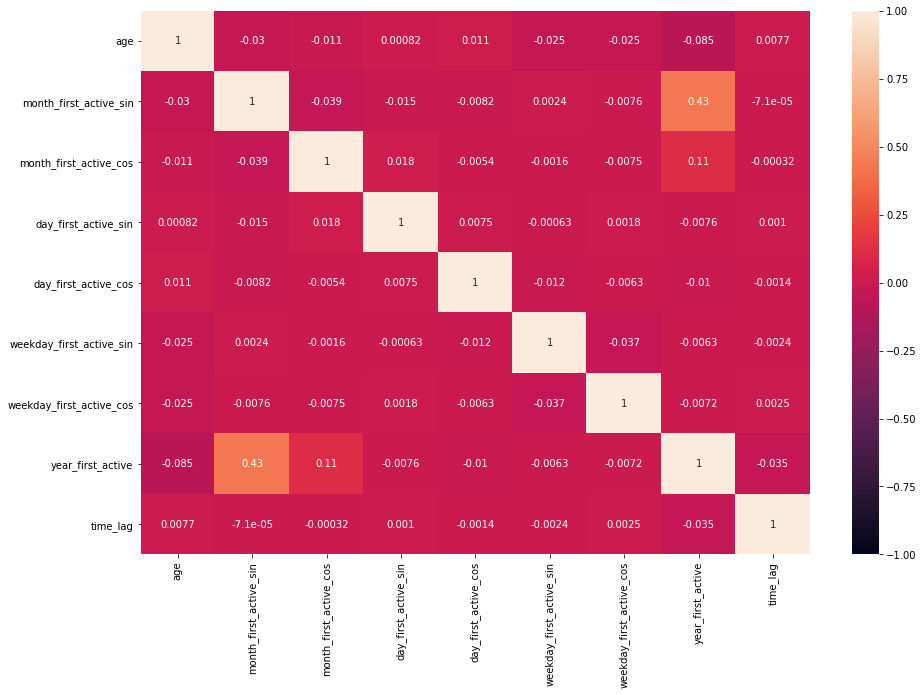

In [0]:
#sn.set(font_scale=1.4)
plt.figure(figsize=(15,10))
sns.heatmap(data_corr.corr(), annot=True, vmax = 1, vmin = -1)
plt.show()

In [0]:
standardize(data, ["year_first_active", "time_lag"])

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,day_first_active,weekday_first_active,month_first_active,year_first_active,time_lag,month_first_active_sin,month_first_active_cos,day_first_active_sin,day_first_active_cos,weekday_first_active_sin,weekday_first_active_cos
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,19,3,3,-4.284400,38.998181,0.866025,5.000000e-01,-0.485302,-0.874347,0.974928,-0.222521
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,MALE,0.120931,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,23,5,5,-4.284400,61.207505,0.866025,-5.000000e-01,-0.968077,-0.250653,-0.433884,-0.900969
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,FEMALE,1.659553,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,9,1,6,-4.284400,39.769788,0.500000,-8.660254e-01,0.998717,-0.050649,0.000000,1.000000
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,FEMALE,0.462847,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,31,5,10,-4.284400,64.009588,-1.000000,-1.836970e-16,-0.201299,0.979530,-0.433884,-0.900969
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,-unknown-,0.377368,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,8,1,12,-4.284400,23.430341,-0.500000,8.660254e-01,0.988468,0.151428,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,2014-06-30 23:56:36,MALE,-0.391942,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF,30,0,6,1.040193,-0.058441,0.500000,-8.660254e-01,-0.394356,0.918958,-0.781831,0.623490
213447,mhewnxesx9,2014-06-30,2014-06-30 23:57:19,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,30,0,6,1.040193,-0.058483,0.500000,-8.660254e-01,-0.394356,0.918958,-0.781831,0.623490
213448,6o3arsjbb4,2014-06-30,2014-06-30 23:57:54,-unknown-,-0.391942,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,30,0,6,1.040193,-0.058516,0.500000,-8.660254e-01,-0.394356,0.918958,-0.781831,0.623490
213449,jh95kwisub,2014-06-30,2014-06-30 23:58:22,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF,30,0,6,1.040193,-0.058544,0.500000,-8.660254e-01,-0.394356,0.918958,-0.781831,0.623490


In [0]:
# Drop colonne duplicate

data.drop(["date_account_created", "timestamp_first_active",
           "day_first_active", "weekday_first_active",
           "month_first_active"], axis = 1, inplace = True)

## Sistemazione valori poco presenti nel dataset

In [0]:
data.columns

Index(['id', 'gender', 'age', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser',
       'country_destination', 'year_first_active', 'time_lag',
       'month_first_active_sin', 'month_first_active_cos',
       'day_first_active_sin', 'day_first_active_cos',
       'weekday_first_active_sin', 'weekday_first_active_cos'],
      dtype='object')

In [0]:
data["signup_method"].value_counts()

basic       152897
facebook     60008
google         546
Name: signup_method, dtype: int64

In [0]:
data["signup_flow"].value_counts()

0     164739
25     14659
12      9329
3       8822
2       6881
24      4328
23      2835
1       1047
6        301
8        240
21       196
5         36
20        14
16        11
15        10
10         2
4          1
Name: signup_flow, dtype: int64

In [0]:
data["language"].value_counts()

en    206314
zh      1632
fr      1172
es       915
ko       747
de       732
it       514
ru       389
pt       240
ja       225
sv       122
nl        97
tr        64
da        58
pl        54
cs        32
no        30
th        24
el        24
id        22
hu        18
fi        14
is         5
ca         5
hr         2
Name: language, dtype: int64

en    206314
zh      1632
fr      1172
es       915
ko       747
de       732
it       514
ru       389
pt       240
ja       225
sv       122
nl        97
tr        64
da        58
pl        54
cs        32
no        30
th        24
el        24
id        22
hu        18
fi        14
is         5
ca         5
hr         2
Name: language, dtype: int64

In [0]:
data["first_affiliate_tracked"].value_counts()

untracked        109232
linked            46287
omg               43982
tracked-other      6156
product            1556
marketing           139
local ops            34
Name: first_affiliate_tracked, dtype: int64

untracked        109232
linked            46287
omg               43982
tracked-other      6156
product            1556
marketing           139
local ops            34
Name: first_affiliate_tracked, dtype: int64

In [0]:
data["signup_app"].value_counts()

Web        182717
iOS         19019
Moweb        6261
Android      5454
Name: signup_app, dtype: int64

Web        182717
iOS         19019
Moweb        6261
Android      5454
Name: signup_app, dtype: int64

In [0]:
data["first_device_type"].value_counts()

Mac Desktop           89600
Windows Desktop       72716
iPhone                20759
iPad                  14339
Other/Unknown         10667
Android Phone          2803
Android Tablet         1292
Desktop (Other)        1199
SmartPhone (Other)       76
Name: first_device_type, dtype: int64

Mac Desktop           89600
Windows Desktop       72716
iPhone                20759
iPad                  14339
Other/Unknown         10667
Android Phone          2803
Android Tablet         1292
Desktop (Other)        1199
SmartPhone (Other)       76
Name: first_device_type, dtype: int64

In [0]:
data["first_browser"].value_counts()

Chrome                  63845
Safari                  45169
Firefox                 33655
-unknown-               27266
IE                      21068
Mobile Safari           19274
Chrome Mobile            1270
Android Browser           851
AOL Explorer              245
Opera                     188
Silk                      124
Chromium                   73
BlackBerry Browser         53
Maxthon                    46
Apple Mail                 36
IE Mobile                  36
Sogou Explorer             33
Mobile Firefox             30
RockMelt                   24
SiteKiosk                  24
Iron                       17
IceWeasel                  13
Pale Moon                  12
Yandex.Browser             11
CometBird                  11
SeaMonkey                  11
Camino                      9
TenFourFox                  8
CoolNovo                    6
wOSBrowser                  6
Avant Browser               4
Opera Mini                  4
Mozilla                     3
TheWorld B

Chrome                  63845
Safari                  45169
Firefox                 33655
-unknown-               27266
IE                      21068
Mobile Safari           19274
Chrome Mobile            1270
Android Browser           851
AOL Explorer              245
Opera                     188
Silk                      124
Chromium                   73
BlackBerry Browser         53
Maxthon                    46
Apple Mail                 36
IE Mobile                  36
Sogou Explorer             33
Mobile Firefox             30
RockMelt                   24
SiteKiosk                  24
Iron                       17
IceWeasel                  13
Pale Moon                  12
Yandex.Browser             11
CometBird                  11
SeaMonkey                  11
Camino                      9
TenFourFox                  8
CoolNovo                    6
wOSBrowser                  6
Avant Browser               4
Opera Mini                  4
Mozilla                     3
TheWorld B

In [0]:
# Alcuni valori pochi presenti nel dataset vengono cambiati in "other"

data["language"] = data["language"].replace(data["language"].value_counts()[data["language"].value_counts() < 10].index.to_list(), "other")

data["first_browser"] = data["first_browser"].replace(data["first_browser"].value_counts()[data["first_browser"].value_counts() < 60].index.to_list(), "other")

data["affiliate_provider"] = data["affiliate_provider"].replace(data["affiliate_provider"].value_counts()[data["affiliate_provider"].value_counts() < 100].index.to_list(), "other")

## Sessions Information

In [0]:
sessions.isna().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [0]:
sessions.rename(columns = {'user_id': 'id'}, inplace=True)

In [0]:
sessions.head()

,id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [0]:
sessions["action"].value_counts()

show                        2768278
index                        843699
search_results               725226
personalize                  706824
search                       536057
                             ...   
faq_experiment_ids             1092
signed_out_modal               1058
15                             1053
authorize                      1040
phone_verification_error       1035
Name: action, Length: 148, dtype: int64

In [0]:
sessions["action_detail"].value_counts()

view_search_results         1776885
p3                          1376550
-unknown-                   1031141
wishlist_content_update      706824
user_profile                 656839
                             ...   
special_offer_field               3
tos_2014                          2
host_refund_guest                 2
host_respond_page                 2
host_standard_suspension          1
Name: action_detail, Length: 155, dtype: int64

view_search_results         1776885
p3                          1376550
-unknown-                   1031141
wishlist_content_update      706824
user_profile                 656839
                             ...   
special_offer_field               3
tos_2014                          2
host_refund_guest                 2
host_respond_page                 2
host_standard_suspension          1
Name: action_detail, Length: 155, dtype: int64

In [0]:
sessions["device_type"].value_counts()

Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
-unknown-                            211279
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64

Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
-unknown-                            211279
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64

In [0]:
sessions["action"] = sessions["action"].replace(sessions["action"].value_counts()[sessions["action"].value_counts() < 1000].index.to_list(), "other")

sessions["action_detail"] = sessions["action_detail"].replace(sessions["action_detail"].value_counts()[sessions["action_detail"].value_counts() < 1000].index.to_list(), "other")

In [0]:
sessions.head()

,id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [0]:
action_count = sessions.groupby(['id', 'action'])['secs_elapsed'].count().unstack()
action_type_count = sessions.groupby(['id', 'action_type'])['secs_elapsed'].count().unstack()
action_detail_count = sessions.groupby(['id', 'action_detail'])['secs_elapsed'].count().unstack()
device_type_sum = sessions.groupby(['id', 'device_type'])['secs_elapsed'].sum().unstack()

sessions_data = pd.concat([action_count, action_type_count, action_detail_count, device_type_sum],axis=1)
sessions_data.columns = sessions_data.columns.map(lambda x: str(x) + '_count')


#Standardize and join
sessions_data = (sessions_data - sessions_data.mean()) / sessions_data.std()


# Device più usato
sessions_data['most_used_device'] = sessions.groupby('id')['device_type'].max()

data = data.join(sessions_data, on='id')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [0]:
# Calcolo di diverse feature su "secs_elapsed"

a = sessions.groupby('id')['secs_elapsed'].agg(
    
        secs_elapsed_sum = np.sum,
        secs_elapsed_mean = np.mean,
        secs_elapsed_min = np.min,
        secs_elapsed_max = np.max,
        secs_elapsed_median = np.median,
        secs_elapsed_std = np.std,
        day_pauses = lambda x: (x > 86400).sum(),
        long_pauses = lambda x: (x > 300000).sum(),
        short_pauses = lambda x: (x < 3600).sum(),
        session_length = np.count_nonzero
)

a["secs_elapsed_skew"] = sessions.groupby("id")["secs_elapsed"].skew()
# Standardize
a = (a - a.mean()) / a.std()

In [0]:
data = data.join(a, on='id')

In [0]:
categorical_features = [
    'gender', 'signup_method', 'signup_flow', 'language',
    'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
    'signup_app', 'first_device_type', 'first_browser', 'most_used_device'
]
data = pd.get_dummies(data, columns=categorical_features)

In [0]:
data.fillna(-99, inplace = True)

# Scrittura file

In [0]:
# salvo csv sistemato
data.to_csv("/content/drive/My Drive/progetto_aml/dataset/train_prepocessed.csv" ,index = False)